In [1]:
# data crawling 과정
# 최초 실행 이후, 이후에는 실행하지 않으며, pickle에 저장된 data를 load에서 사용하는 형식이다.

from selenium import webdriver
from pandas.io.html import read_html
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import re


# premier league 선수/팀들의 summary을 기반으로 crawling을 수행한다.

# 선수 데이터 페이지
# https://1xbet.whoscored.com/Regions/252/Tournaments/2/Seasons/8618/Stages/19793/PlayerStatistics/England-Premier-League-2021-2022
# 팀 데이터 페이지
# https://1xbet.whoscored.com/Regions/252/Tournaments/2/Seasons/8618/Stages/19793/TeamStatistics/England-Premier-League-2021-2022

# crawling 참고 페이지 : https://m.blog.naver.com/chunsa0127/222048197119


# 실행 시간을 구하기 위한 decorator을 정의한다.
def checkTime(func):
    def wrapper_fn(*args, **kwargs):
        print(time.strftime('[%Y-%m-%d %H:%M]', time.localtime()))
        before_time = time.time()
        result = func(*args, **kwargs)
        after_time = time.time()
        print("실행시간은:", round(after_time - before_time, 2), "s")
        return result
    
    return wrapper_fn

# 각 선수의 정보를 얻는 함수
@checkTime
def get_player_data(url, sleep_time) :
    #open webdriver
    chrome_driver = '/usr/local/bin/chromedriver'
    driver = webdriver.Chrome(chrome_driver)
    driver.get(url)
    
    #click 'all players' button
    time.sleep(sleep_time)
    all_player = driver.find_element_by_link_text('All players')
    all_player.click()
    
    #get the total page number
    time.sleep(sleep_time)
    page = driver.find_element_by_link_text('last')
    total_page = int(page.get_attribute('data-page'))
    
    #create the dataframe
    df_player = pd.DataFrame(columns = ['Player', 'Player.1', 'Apps', 'Mins', 'Goals', 'Assists',
                                        'Yel', 'Red', 'SpG', 'PS%', 'AerialsWon', 'MotM', 'Rating'])
    
    #crawling the table
    for i in np.arange(total_page):
        time.sleep(sleep_time)
        table = driver.find_element_by_xpath('//*[@id="statistics-table-summary"]')
        table_html= table.get_attribute('innerHTML')
        df2 = read_html(table_html)[0]
        df_player = pd.concat([df_player, df2], axis=0)
        driver.find_element_by_link_text('next').click()
        
    return df_player

# 각 팀의 정보를 얻는 함수
@checkTime
def get_team_data(url, sleep_time) :
    #open webdriver
    chrome_driver = '/usr/local/bin/chromedriver'
    driver = webdriver.Chrome(chrome_driver)
    driver.get(url)
    
    #create the dataframe
    df_team = pd.DataFrame(columns = ['Team', 'Goals', 'Shots pg', 'Discipline', 'Possession%',
                                        'Pass%', 'AerialsWon', 'Rating'])
    
    #crawling the table
    # 팀의 정보를 얻는 경우, 여러 페이지가 아닌, 한 페이지에 모든 데이터를 얻기 때문에 loop, next 등이 필요하지 않다.
    time.sleep(sleep_time)
    table = driver.find_element_by_xpath('//*[@id="statistics-team-table-summary"]')
    table_html= table.get_attribute('innerHTML')
    df2 = read_html(table_html)[0]
    df_team = pd.concat([df_team, df2], axis=0)
        
    return df_team

url1 = "https://1xbet.whoscored.com/Regions/252/Tournaments/2/Seasons/8618/Stages/19793/PlayerStatistics/England-Premier-League-2021-2022"
url2 = "https://1xbet.whoscored.com/Regions/252/Tournaments/2/Seasons/8618/Stages/19793/TeamStatistics/England-Premier-League-2021-2022"

# crawling과 함께 crawling 수행에 걸리는 시간을 측정한다.
df_player = get_player_data(url1, 1)
df_team = get_team_data(url2, 1)

# crawling은 1번만 수행하며, 이후에는 pickle을 통해 data를 불러온다
# time.sleep 을 사용하기 때문에 crawling 수행 시간이 비교적 오래 걸리기 때문이다.

# player 저장
with open('player_data.txt', "wb") as f1:
    pickle.dump(df_player, f1)

# team 저장
with open('team_data.txt', "wb") as f2:
    pickle.dump(df_team, f2)

[2022-06-22 23:30]
실행시간은: 76.53 s
[2022-06-22 23:31]
실행시간은: 10.36 s


In [4]:
# 선수 data 전처리 과정

# data crawling을 통해 얻어낸 data를 바탕으로, pandas Dataframe을 정리한다.
# 선수 data는 crawing을 통해 얻어낸 DF를 바탕으로 전처리하여 pandas DataFrame으로 저장한다.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import re

# pickle에서 data 불러오기
with open('player_data.txt', "rb") as f1:
    df_player = pickle.load(f1)

# 개선 사항 : Player, Player.1에 중복되는 정보가 존재하며, 이름, 팀, 나이 등이 분리되지 않은 형태이다. 따라서 이를 해결한다.
# index 정렬
df_player = df_player.reset_index()
df_player.drop(['index','Player'] , axis=1, inplace=True)

# Player.1의 data 분리 (crawling 참고 사이트 참고)
split = df_player['Player.1'].str.split(',')
name_list = []
age_list = []
position1_list = []
position2_list = []

for i in range(len(split)):
    name = split[i][0]
    age = split[i][1]
    position1 = split[i][2]
    
    # 2nd position이 존재하는 경우
    if len(split[i]) > 3:
        position2 = split[i][3]
    # 존재하지 않는 경우
    else:
        position2 = np.nan
    name_list.append(name)
    age_list.append(age)
    position1_list.append(position1)
    position2_list.append(position2)

# name_list 에 존재하는 형태는 이름 + " " + 팀이름 형태이다. 따라서 이를 분리해주어야 한다.
# 또한 팀이름은 df_team에서의 Team column과는 다른 형식으로 저장되어 있다.
# 따라서 별도의 list를 만들어 추출해내야 한다.
team_name = ['Man City', 'Liverpool', 'Chelsea', 'Tottenham', 'West Ham',
             'Arsenal', 'Man Utd', 'Crystal Palace', 'Leicester', 'Brighton',
            'Wolves', 'Aston Villa', 'Burnley', 'Brentford', 'Southampton',
            'Newcastle', 'Everton', 'Leeds', 'Watford', 'Norwich']

new_name_list = []
new_team_list = []

for i in range(len(name_list)):
    for j in range(len(team_name)):
        if team_name[j] in name_list[i]:
            new_name_list.append(name_list[i].replace(" "+team_name[j], ""))
            new_team_list.append(team_name[j])

df_player['name'] = new_name_list
df_player['team'] = new_team_list
df_player['age'] = age_list
df_player['position1']=position1_list
df_player['position2'] = position2_list
df_player.drop('Player.1', axis =1, inplace=True)

# column의 순서 정렬
df_player = df_player.iloc[:,[11,12,13,14,0,1,2,3,4,5,6,7,8,9,10]]

# df 확인
df_player

,name,team,age,position1,Apps,Mins,Goals,Assists,Yel,Red,SpG,PS%,AerialsWon,MotM,Rating
0,Kevin De Bruyne,Man City,30,M(CLR),25(5),2205,15,8,2,-,2.6,82.5,0.4,4,7.64
1,Mohamed Salah,Liverpool,30,AM(CLR),30(5),2763,23,13,1,-,4.0,79.9,0.2,7,7.54
2,Son Heung-Min,Tottenham,29,M(CLR),35,3021,23,7,2,-,2.5,86.6,0.5,6,7.52
3,Trent Alexander-Arnold,Liverpool,23,D(R),32,2854,2,12,2,-,1.6,78.1,0.5,5,7.51
4,Kenedy,Chelsea,26,D(L),1,59,-,1,-,-,1.0,73.9,-,-,7.46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
542,Freddie Woodman,Newcastle,25,GK,4,360,-,-,-,-,-,58.9,-,-,5.81
543,Sead Kolasinac,Arsenal,29,D(CL),1(1),91,-,-,1,-,-,92.9,-,-,5.72
544,Isaac Price,Everton,18,Midfielder,0(1),12,-,-,-,-,1,50.0,-,-,5.70
545,Jonas Lössl,Brentford,33,GK,2,180,-,-,-,-,-,65.5,-,-,5.55


In [5]:
# 팀 data 전처리 과정
# pickle에서 data 불러오기
with open('team_data.txt', "rb") as f2:
    df_team = pickle.load(f2)

# 개선 사항 : Team name에서 숫자와 팀 이름을 분리해야 한다.
split = df_team['Team'].str.split('.')
team_data = []
for i in range(len(split)):
    team_data.append(split[i][1][1:])
df_team['Team'] = team_data

#df 확인
df_team

,Team,Goals,Shots pg,Discipline,Possession%,Pass%,AerialsWon,Rating
0,Manchester City,99,18.8,421,68.2,89.7,12.7,7.12
1,Liverpool,94,19.2,501,63.1,84.9,15.1,7.05
2,Chelsea,76,15.6,631,62.2,87.1,14.3,6.92
3,Tottenham,69,12.9,671,51.9,85.0,14.9,6.88
4,West Ham,60,11.8,473,47.4,80.6,16.9,6.75
5,Arsenal,61,15.5,604,52.6,83.4,12.4,6.71
6,Manchester United,57,13.4,752,52.1,82.8,14.7,6.71
7,Crystal Palace,50,10.8,671,50.8,80.3,16.1,6.71
8,Leicester,62,11.4,551,51.8,81.8,14.0,6.70
9,Brighton,42,12.9,732,54.3,81.7,15.1,6.70


In [6]:
# team oop 형성
# team 객체이다. df_team의 정보를 각 객체에 저장할 수 있으며, 관련된 method 또한 존재한다.
# instance variable은 private 형태로, @property로 접근할 수 있도록 설정한다.

class team:
    def __init__(self, name, goals, shotspg, possession_percent, pass_percent, rating):
        self.__player_index = []
        self.__name = name
        self.__goal_percent = round((goals/(shotspg*38))*100,2)
        self.__possession_percent = possession_percent
        self.__pass_percent = pass_percent
        self.__rating = rating
    
    #property로 접근할 수 있도록 정의해준다.
    @property
    def player_index(self):
        return self.__player_index
    
    @property
    def name(self):
        return self.__name
    
    @property
    def goal_percent(self):
        return self.__goal_percent
    
    @property
    def possession_percent(self):
        return self.__possession_percent
    
    @property
    def pass_percent(self):
        return self.__pass_percent
    
    @property
    def rating(self):
        return self.__rating
    
    
    def append(self, data):
        self.__player_index.append(i)
    
    # 해당 팀 선수들의 평균 rating을 구하는 method
    def calculate_avg_rating(self):
        ratesum = 0
        for i in self.player_index:
            ratesum += df_player.loc[i]['Rating']
        
        rateavg = ratesum/len(self.player_index)
        return round(rateavg, 2)
    
    # 상위 11명의 평균 rating을 구하는 method
    def calculate_11_rating(self):
        ratesum = 0
        for i in range(11):
            ratesum += df_player.loc[self.player_index[i]]['Rating']
        
        rateavg = ratesum/11
        return round(rateavg, 2)
    
    # 평균 rating과 team rating을 비교해서 감독을 평가하는 method
    def evaluate_head_coach(self):
        avg_rating = self.calculate_avg_rating()
                
        # 0.15는 0.05, 0.1 등의 대입을 통한 경험에 의한 값이다.
        if self.__rating - avg_rating >= 0.15:
            print(self.name, "head coach done well!")
        
        else:
            print(self.name, "better change head coach...")
        
        print("team rating =", self.__rating, "avg rating =", avg_rating, "\n")
    
    #해당 팀의 선수들을 모두 출력해주는 method
    def print_player_list(self):
        for i in self.player_index:
            print(df_player.loc[i]['name'])

#실제 객체 구현, 순위대로 list에 저장한다.
team_instance_list = []
for i in range(20):
    team_instance_list.append(team(df_team.loc[i]['Team'], df_team.loc[i]['Goals'],
                             df_team.loc[i]['Shots pg'], df_team.loc[i]['Possession%'],
                             df_team.loc[i]['Pass%'], df_team.loc[i]['Rating']))

for i in range(len(df_player)):
    for j in range(len(team_name)):
        if df_player.loc[i]['team'] == team_name[j]:
            team_instance_list[j].append(i)

In [7]:
# data 분석 과정 1
# 팀 rating과 선수단 rating을 비교하며, 해당 팀의 감독이 잘 수행했는지, 교체가 필요한지를 평가한다.
# 또한 각 팀의 rating과 평균 rating 출력한다.

for i in range(20):
    team_instance_list[i].evaluate_head_coach()

Manchester City head coach done well!
team rating = 7.12 avg rating = 6.94 

Liverpool better change head coach...
team rating = 7.05 avg rating = 6.9 

Chelsea better change head coach...
team rating = 6.92 avg rating = 6.89 

Tottenham better change head coach...
team rating = 6.88 avg rating = 6.74 

West Ham head coach done well!
team rating = 6.75 avg rating = 6.56 

Arsenal head coach done well!
team rating = 6.71 avg rating = 6.56 

Manchester United better change head coach...
team rating = 6.71 avg rating = 6.58 

Crystal Palace better change head coach...
team rating = 6.71 avg rating = 6.6 

Leicester better change head coach...
team rating = 6.7 avg rating = 6.63 

Brighton better change head coach...
team rating = 6.7 avg rating = 6.59 

Wolverhampton better change head coach...
team rating = 6.69 avg rating = 6.6 

Aston Villa head coach done well!
team rating = 6.68 avg rating = 6.46 

Burnley better change head coach...
team rating = 6.65 avg rating = 6.58 

Brentford h

In [8]:
# data 분석 과정 2
# 평균 rating을 통해 20개 팀의 등수를 결정하며, 실제 등수와 비교한다.

rating_array = []
for i in range(20):
    rating_array.append((team_instance_list[i].name,
                         team_instance_list[i].calculate_avg_rating()))

# rating 순으로 정렬
rating_array = sorted(rating_array, key = lambda x:x[1], reverse = True)

same_count = 0
for i in range(20):
    if rating_array[i][0] == team_instance_list[i].name:
        same_count += 1
same_count = round(same_count/20, 2)
print(f"예측한 등수가 정확할 확률은 : {same_count * 100}%")

예측한 등수가 정확할 확률은 : 25.0%


In [9]:
# data 분석 과정 3
# 위와 동일하게 평균 rating을 통해 20개 팀의 등수를 결정하며, 실제 등수와 비교한다.
# 축구라는 스포츠의 특성상 상위 11명의 선수가 중요하다. 따라서 각 팀의 상위 11명의 평균 rating을 비교한다.

rating_array = []
for i in range(20):
    rating_array.append((team_instance_list[i].name,
                         team_instance_list[i].calculate_11_rating()))

# rating 순으로 정렬
rating_array = sorted(rating_array, key = lambda x:x[1], reverse = True)

same_count = 0
for i in range(20):
    if rating_array[i][0] == team_instance_list[i].name:
        same_count += 1
same_count = round(same_count/20, 2)
print(f"예측한 등수가 정확할 확률은 : {same_count * 100}%")

예측한 등수가 정확할 확률은 : 40.0%


In [10]:
# data 분석 과정 4
# 위와 동일한 방식으로, 팀 rating을 바탕으로 정렬하며 비교한다.

rating_array = []
for i in range(20):
    rating_array.append((team_instance_list[i].name,
                         team_instance_list[i].rating))

# rating 순으로 정렬
rating_array = sorted(rating_array, key = lambda x:x[1], reverse = True)

same_count = 0
for i in range(20):
    if rating_array[i][0] == team_instance_list[i].name:
        same_count += 1
same_count = round(same_count/20, 2)
print(f"예측한 등수가 정확할 확률은 : {same_count * 100}%")

예측한 등수가 정확할 확률은 : 100.0%


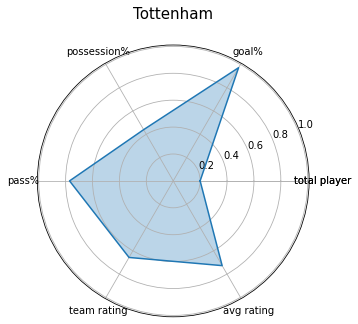

In [11]:
# data 시각화 1
# 여러 게임에서, 능력치를 육각형 형태로 표현하곤 하며, 이는 '레이더 차트' 라는 이름으로 실생활에 다양한 영역에서 적용된다.
# 각 팀의 객체에서 저장되어 있는 능력치를 바탕으로 정규화를 수행한다. (rescaling)
# 정규화는 각 데이터에 대해 (X - min) / (max - min) 형태로 0~1의 값을 가질 수 있도록 설정했다.


# 정규화를 위한 max_data, min_data 이다.
# max_data 저장
max_data = []
# 선수 총 인원
max_data.append(max(len(i.player_index) for i in team_instance_list))

# goal_percent
max_data.append(max(i.goal_percent for i in team_instance_list))

# possession_percet
max_data.append(max(i.possession_percent for i in team_instance_list))

# pass_percent
max_data.append(max(i.pass_percent for i in team_instance_list))

# team_rating
max_data.append(max(i.rating for i in team_instance_list))

# avg_rating -> 11명을 기준으로
max_data.append(max(i.calculate_11_rating() for i in team_instance_list))

# min_data 저장
min_data = []
# 선수 총 인원
min_data.append(min(len(i.player_index) for i in team_instance_list))

# goal_percent
min_data.append(min(i.goal_percent for i in team_instance_list))

# possession_percet
min_data.append(min(i.possession_percent for i in team_instance_list))

# pass_percent
min_data.append(min(i.pass_percent for i in team_instance_list))

# team_rating
min_data.append(min(i.rating for i in team_instance_list))

# avg_rating -> 11명을 기준으로
min_data.append(min(i.calculate_11_rating() for i in team_instance_list))


# 팀 순위를 입력받았을 때, 해당 팀의 능력치를 plt을 바탕으로 radar chart로 만들어낼 수 있는 함수이다.
def print_radar_chart(rank):
    categories = ["total player", "goal%", "possession%", "pass%",
                  "team rating", "avg rating", "total player"]
    label_loc = np.linspace(start = 0, stop = 2*np.pi, num = len(categories))
    
    norm_data = [len(team_instance_list[rank-1].player_index),
                team_instance_list[rank-1].goal_percent,
                team_instance_list[rank-1].possession_percent,
                team_instance_list[rank-1].pass_percent,
                team_instance_list[rank-1].rating,
                team_instance_list[rank-1].calculate_11_rating()]
    
    for i in range(len(norm_data)):
        norm_data[i] = (norm_data[i]-min_data[i])/(max_data[i]- min_data[i])
    norm_data.append(norm_data[0])
    
    plt.figure(figsize = (5, 5))
    ax = plt.subplot(polar = True)
    plt.xticks(label_loc, labels = categories, fontsize = 10)
    ax.plot(label_loc, norm_data)
    ax.fill(label_loc, norm_data, alpha = 0.3)
    ax.set_title(team_instance_list[rank-1].name + "\n", size = 15, va='bottom')
    plt.show()

# 21-22 시즌 4위 팀인 토트넘의 radar chart를 출력해본다.
print_radar_chart(4)

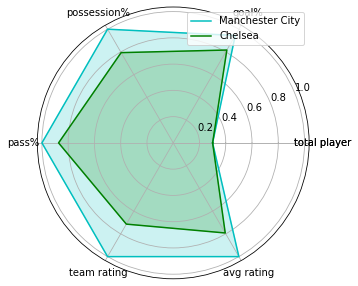

In [12]:
# 데이터 시각화 2
# 위의 레이더 차트를 바탕으로, 두 팀간의 비교를 그림으로 볼 수 있는 radar_compare 함수를 구현한다.
# input으로 rank1, rank2, color1, color2 을 받는다. 이를 통해 각 radar graph의 색을 결정할 수 있다.
def radar_compare(rank1, rank2, c1, c2):
    categories = ["total player", "goal%", "possession%", "pass%",
                  "team rating", "avg rating", "total player"]
    label_loc = np.linspace(start = 0, stop = 2*np.pi, num = len(categories))
    
    norm_data1 = [len(team_instance_list[rank1-1].player_index),
                team_instance_list[rank1-1].goal_percent,
                team_instance_list[rank1-1].possession_percent,
                team_instance_list[rank1-1].pass_percent,
                team_instance_list[rank1-1].rating,
                team_instance_list[rank1-1].calculate_11_rating()]
    
    for i in range(len(norm_data1)):
        norm_data1[i] = (norm_data1[i]-min_data[i])/(max_data[i]- min_data[i])
    norm_data1.append(norm_data1[0])
    
    norm_data2 = [len(team_instance_list[rank2-1].player_index),
                team_instance_list[rank2-1].goal_percent,
                team_instance_list[rank2-1].possession_percent,
                team_instance_list[rank2-1].pass_percent,
                team_instance_list[rank2-1].rating,
                team_instance_list[rank2-1].calculate_11_rating()]
    
    for i in range(len(norm_data2)):
        norm_data2[i] = (norm_data2[i]-min_data[i])/(max_data[i]- min_data[i])
    norm_data2.append(norm_data2[0])
    
    plt.figure(figsize = (5, 5))
    ax = plt.subplot(polar = True)
    plt.xticks(label_loc, labels = categories, fontsize = 10)
    ax.plot(label_loc, norm_data1, c = c1, label = team_instance_list[rank1-1].name)
    ax.fill(label_loc, norm_data1, alpha = 0.2, c = c1)
    ax.plot(label_loc, norm_data2, c = c2, label = team_instance_list[rank2-1].name)
    ax.fill(label_loc, norm_data2, alpha = 0.2, c = c2)
    plt.legend(loc='upper right')
    plt.show()


radar_compare(1, 3, 'c', 'g')

In [13]:
# 정규식을 이용한 데이터 검색
# 정규식을 바탕으로 regex에 적합한 선수들의 이름과 팀을 출력한다.
def search_by_regex(regex):
    for i in df_player.values.tolist():
        if re.search(regex, i[0]):
            print("name :", i[0], " team :", i[1])
    
# 이름에 De 가 포함된 축구 선수와 팀을 출력한다.
search_by_regex('De')

name : Kevin De Bruyne  team : Man City
name : Dejan Kulusevski  team : Tottenham
name : Declan Rice  team : West Ham
name : Emmanuel Dennis  team : Watford
name : Demarai Gray  team : Everton
name : Kiernan Dewsbury-Hall  team : Leicester
name : Fabian Delph  team : Everton
name : Dele Alli  team : Tottenham
name : Liam Delap  team : Man City
name : Leander Dendoncker  team : Wolves
name : Dele Alli  team : Everton
name : Troy Deeney  team : Watford


In [14]:
# 팀의 선수 명단 출력 method
team_instance_list[3].print_player_list()

Son Heung-Min
Harry Kane
Rodrigo Bentancur
Dejan Kulusevski
Pierre-Emile Højbjerg
Matt Doherty
Sergio Reguilón
Cristian Romero
Emerson Royal
Davinson Sánchez
Lucas Moura
Hugo Lloris
Ben Davies
Eric Dier
Ryan Sessegnon
Oliver Skipp
Dele Alli
Japhet Tanganga
Tanguy Ndombele
Harry Winks
Giovani Lo Celso
Steven Bergwijn
Dane Scarlett
Bryan Gil
Joe Rodon
